In [11]:
#--- Importing libararies ---
from __future__ import division
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
from keras.optimizers import Adam
from keras import layers
from functools import reduce
from phased_lstm_keras.PhasedLSTM import PhasedLSTM as PLSTM
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#--- Scaling the measurements ---
def scale(a):
	a_min = np.nanmin(a, 0)
	a_max = np.nanmax(a, 0)
	return (a - a_min) / (a_max - a_min), a_min, a_max

#--- Unscaling the measurements ---
def unscale(a_sc, amin, amax):
	return a_sc * (amax - amin) + amin

#--- factorization step ---
def factors(n):
	return set(reduce(list.__add__,
					  ([i, n // i] for i in range(1, int(pow(n, 0.5) + 1)) if n % i == 0)))

#--- MSE function to calculat the accuracy ---
def NSE(y_observed, y_predicted):
	NSE_coefficient = 1 - sum((y_predicted - y_observed) ** 2) / sum((y_observed - np.mean(y_observed)) ** 2)
	return NSE_coefficient


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [12]:
#--- reading the dataset, splitting and defining the input/output data
def data_preparation():
    dataset = read_csv('water_quality.csv', header=0, index_col=0)
    values = dataset.values
    values = values.astype('float32')
    scaled, value_min, value_max = scale(values)
    n_hours_forecast = 6
    n_hours = 18
    n_features = 4
    reframed = series_to_supervised(scaled, n_hours, n_hours_forecast)
    values = reframed.values
    batchsize = 720
    values_to_cut = values.shape[0] - values.shape[0] // batchsize * batchsize
    train_portion = 0.6
    test_portion = 0.4
    n_train_samples = int(train_portion * values.shape[0] - (train_portion * values.shape[0]) % batchsize)
    train = values[:n_train_samples, :]
    test = values[n_train_samples:, :]
    # split into input and outputs
    n_obs = n_hours * n_features
    return n_obs,train,test

In [4]:
seed = 1000
def baseline_model():
	# create model
	model = Sequential()
	model.add(LSTM(20, input_shape=(train_X_reshaped.shape[1], train_X_reshaped.shape[2]), return_sequences=False, activation='tanh'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model

In [5]:
def features_prediction(n_obs,train,test):
    NSE_calc_list = []
    test_y_unscaled_list = []
    y_predicted_unscaled_list = []
    for i in range(-4,0):
        train_X, train_y = train[:, :n_obs], train[:, i]
        test_X, test_y = test[:, :n_obs], test[:, i]
        train_X_reshaped = train_X.reshape((train_X.shape[0], n_hours, n_features))
        test_X_reshaped = test_X.reshape((test_X.shape[0], n_hours, n_features))
        model = KerasRegressor(build_fn=baseline_model, epochs=ep, batch_size=72, verbose=0)
        model.fit(train_X_reshaped,train_y,verbose=2)
        y_predicted = model.predict(test_X_reshaped)
        y_predicted_unscaled = unscale(y_predicted,value_min[0],value_max[0])
        y_predicted_unscaled_list.append(y_predicted_unscaled)
        test_y_unscaled = unscale(test_y, value_min[0], value_max[0])
        test_y_unscaled_list.append(test_y_unscaled)
        NSE_calc = NSE(test_y_unscaled,y_predicted_unscaled)
        NSE_calc_list.append(NSE_calc)
    return NSE_calc_list,test_y_unscaled_list,y_predicted_unscaled_list

In [13]:
n_obs,train,test=data_preparation()

In [ ]:
NSE_calc_list,test_y_unscaled_list,y_predicted_unscaled_list = features_prediction(n_obs,train,test)

In [73]:
print(NSE_calc_list)

def results(test_y_unscaled_list,y_predicted_unscaled_list):
    for i in range(4):
        plt.subplot( 2, 2, i+1 )
        plt.plot(test_y_unscaled_list[i], label='measured')
        plt.plot(y_predicted_unscaled_list[i], '-',label='predicted')
        plt.legend()
        plt.margins(0,0)
        plt.grid()
    plt.show()

[0.8992167172107014, 0.8785729819287834, 0.24115445691013704, 0.8030596270436314]


In [ ]:
plt.figure(figsize=(16,10))
results(test_y_unscaled_list,y_predicted_unscaled_list)

#  Many to Many 

In [14]:
n_hours_forecast = 6
n_hours = 18
n_features = 4
n_obs = n_hours * n_features

In [15]:
# many(18*4) to many(6*4)
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
print(train_X.shape,train_y.shape)
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print(test_X.shape,test_y.shape)

(17280, 72) (17280, 24)
(12175, 72) (12175, 24)


In [16]:
# need to reshape X arrays for use with LSTM
train_X_reshaped = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X_reshaped = test_X.reshape((test_X.shape[0], n_hours, n_features))

(17280, 18, 4)
(12175, 18, 4)


In [20]:
# need to reshape Y arrays for use with LSTM
train_y_reshaped = train_y.reshape((train_y.shape[0], n_hours_forecast, n_features))
test_y_reshaped = test_y.reshape((test_y.shape[0], n_hours_forecast, n_features))

In [22]:
print(train_X_reshaped.shape)
print(train_y_reshaped.shape)
print(test_X_reshaped.shape)
print(test_y_reshaped.shape)

(17280, 18, 4)
(17280, 6, 4)
(12175, 18, 4)
(12175, 6, 4)


In [30]:
# many to many
# # First trial
# # create LSTM
# model = Sequential()
# model.add(LSTM(10, input_shape=(18, 4), return_sequences=True))
# model.add(TimeDistributed(Dense(6)))
# model.compile(loss='mean_squared_error', optimizer='adam')
# print(model.summary())
# # Second trail
# model = Sequential()  
# model.add(LSTM(input_dim=4, output_dim=4, return_sequences=False))  
# model.add(RepeatVector(6))
# model.add(LSTM(output_dim=4, return_sequences=True))  
# model.add(TimeDistributed(Dense(1)))
# model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])  
# model.summary()

In [269]:
def create_model(steps_before, steps_after, feature_count):
    
    model = Sequential()
    model.add(LSTM(input_dim=feature_count, output_dim=10, return_sequences=False))
    model.add(RepeatVector(steps_after))
    model.add(LSTM(output_dim=10, return_sequences=True))
    model.add(TimeDistributed(Dense(feature_count)))
    model.add(Activation('linear'))  
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])  
    return model

In [270]:
model = create_model(18, 6, 4)

/usr/lib/python3/dist-packages/ipykernel/__main__.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/usr/lib/python3/dist-packages/ipykernel/__main__.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, input_shape=(None, 4), units=10)`
/usr/lib/python3/dist-packages/ipykernel/__main__.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=10)`


In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10)                600       
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 6, 10)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 6, 10)             840       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 6, 4)              44        
_________________________________________________________________
activation_3 (Activation)    (None, 6, 4)              0         
Total params: 1,484
Trainable params: 1,484
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = model.fit(train_X_reshaped, train_y_reshaped, batch_size=1, nb_epoch=1, validation_split=0.05)

Train on 16416 samples, validate on 864 samples
Epoch 1/1
    7/16416 [..............................] - ETA: 6:38 - loss: 0.0015 - acc: 0.9762

/usr/local/lib/python3.5/dist-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


16416/16416 [==============================] - 351s 21ms/step - loss: 7.9895e-04 - acc: 0.9494 - val_loss: 0.0010 - val_acc: 0.8601


In [38]:
predict = model.predict(test_X_reshaped)

In [48]:
y_predicted_unscaled = unscale(predict,np.nanmin(predict, 0)[0],np.nanmax(predict, 0)[0])

In [49]:
test_y_unscaled = unscale(test_y_reshaped,np.nanmin(test_y_reshaped, 0)[0],np.nanmax(test_y_reshaped, 0)[0])

In [50]:
NSE_calc = NSE(test_y_unscaled,y_predicted_unscaled)

In [73]:
y_predicted_unscaled.shape,test_y_unscaled.shape

((12175, 6, 4), (12175, 6, 4))

In [255]:
s = np.arange(1,5)
s[0]

1

In [248]:
range(len(s))

range(0, 4)

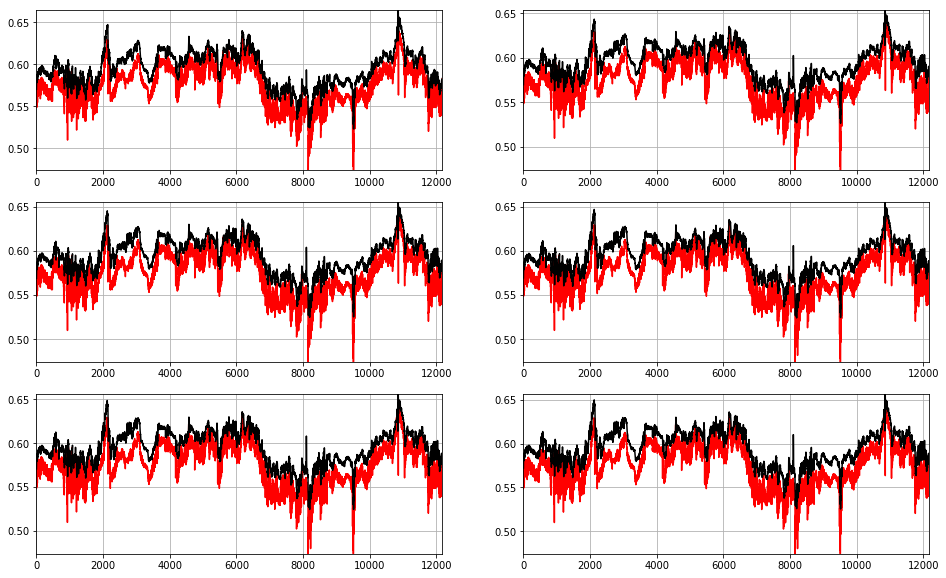

In [265]:
colors = ['r','b','y','g']
features_names = ['Specific Conductance','Dissolved Oxygen','Chlorophyll','Turbidity']
plt.figure(figsize=(16,10))
for i in range(len(test_y_unscaled[1])):
    for j in range(0,1):
            plt.subplot( 3, 2, i+1)
            plt.plot(test_y_unscaled[:,i,j], colors[j], label='measured')
            plt.plot(y_predicted_unscaled[:,i,j],"k-", label='predicted')
            plt.margins(0,0)
            plt.grid()
plt.show()        

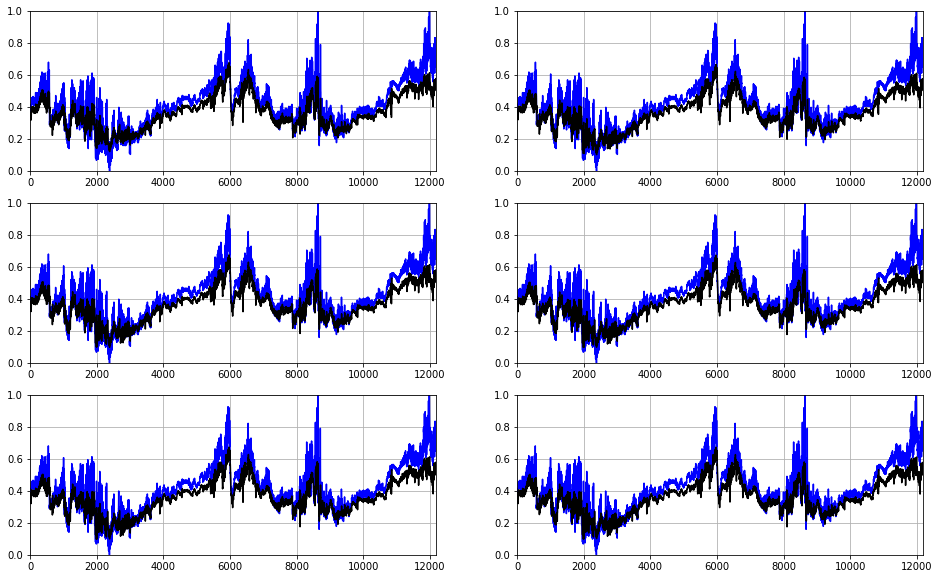

In [266]:
colors = ['r','b','y','g']
features_names = ['Specific Conductance','Dissolved Oxygen','Chlorophyll','Turbidity']
plt.figure(figsize=(16,10))
for i in range(len(test_y_unscaled[1])):
    for j in range(1,2):
            plt.subplot( 3, 2, i+1)
            plt.plot(test_y_unscaled[:,i,j], colors[j], label='measured')
            plt.plot(y_predicted_unscaled[:,i,j],"k-", label='predicted')
            plt.margins(0,0)
            plt.grid()
plt.show()        

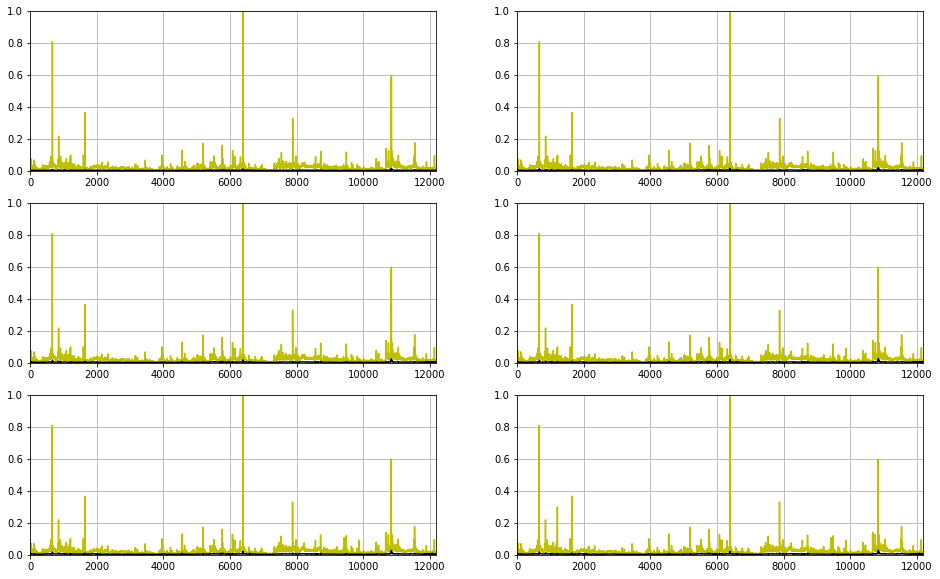

In [267]:
colors = ['r','b','y','g']
features_names = ['Specific Conductance','Dissolved Oxygen','Chlorophyll','Turbidity']
plt.figure(figsize=(16,10))
for i in range(len(test_y_unscaled[1])):
    for j in range(2,3):
            plt.subplot( 3, 2, i+1)
            plt.plot(test_y_unscaled[:,i,j], colors[j], label='measured')
            plt.plot(y_predicted_unscaled[:,i,j],"k-", label='predicted')
            plt.margins(0,0)
            plt.grid()
plt.show()        

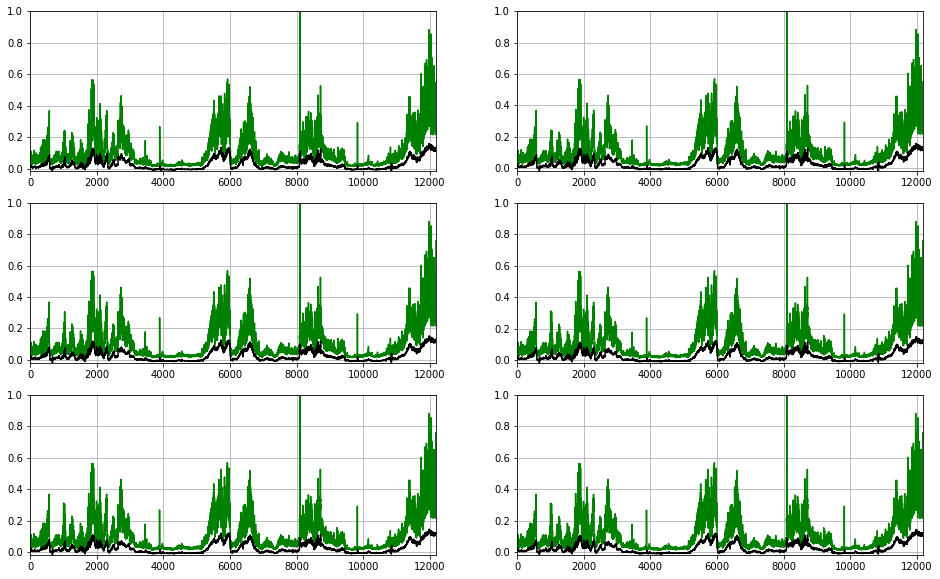

In [268]:
colors = ['r','b','y','g']
features_names = ['Specific Conductance','Dissolved Oxygen','Chlorophyll','Turbidity']
plt.figure(figsize=(16,10))
for i in range(len(test_y_unscaled[1])):
    for j in range(3,4):
            plt.subplot( 3, 2, i+1)
            plt.plot(test_y_unscaled[:,i,j], colors[j], label='measured')
            plt.plot(y_predicted_unscaled[:,i,j],"k-", label='predicted')
            plt.margins(0,0)
            plt.grid()
plt.show()        